In [58]:
import matplotlib
import pathlib

import mne
print(mne.__version__)

from scipy.io import loadmat, savemat
from fracModel import fracOrdUU
import os
import numpy as np

0.24.1


In [59]:
#To plot graphs using Qt console
matplotlib.use('Qt5Agg')

#### Loading EEG data

In [60]:
#Locations
location_al = "data\data_set_IVa_al_mat\\100Hz\data_set_IVa_al.mat"
location_AdataL = "data/AdataL.npz"

In [61]:
mat = loadmat(location_al)

In [62]:
sfreq = mat['nfo']['fs'][0][0][0][0]

EEGdata = mat['cnt'].T
EEGdata = 1e-1*EEGdata   #To convert to uV

nchannels, nsamples = EEGdata.shape

ch_names = [s[0] for s in mat['nfo']['clab'][0][0][0]]

event_onsets = mat['mrk'][0][0][0]
event_codes = mat['mrk'][0][0][1]

labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in mat['mrk']['className'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]

xpos = mat['nfo']['xpos'][0][0]
ypos = mat['nfo']['ypos'][0][0]

nclasses = len(cl_lab)
nevents = len(event_onsets.transpose())

In [63]:
trials = {}

win = np.arange(int(0*sfreq), int(3*sfreq))    # Epoch size of each trial (0 to 3 sec)
nsamples = len(win)

In [64]:
for cl, code in zip(cl_lab, np.unique(event_codes)):
    cl_onsets = event_onsets[event_codes == code]
    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))
    for i, onset in enumerate(cl_onsets):
        trials[cl][:, :, i] = EEGdata[:, win+onset]

In [8]:
right = np.rollaxis(trials[cl1], 2, 0)
foot = np.rollaxis(trials[cl2], 2, 0)

In [9]:
data = np.concatenate([right, foot])

In [10]:
Y = np.concatenate([-np.ones(right.shape[0]), np.ones(foot.shape[0])])    # Labeling right as -1 and foot as 1

In [11]:
# Converting to BIDS using mne
n_channels = 118

info = mne.create_info(
ch_names = ch_names,
ch_types = ['eeg']*nchannels,
sfreq = sfreq)

layout_pos = np.concatenate([xpos, ypos], axis = 1)

layout = mne.channels.generate_2d_layout(
xy = layout_pos,
ch_names = ch_names,
name = "EEG custom layout")

In [12]:
event_id = dict(right = -1, foot = 1)

eventLength = Y.shape[0]
ev = [i*sfreq*3 for i in range(eventLength)]

events = np.column_stack((np.array(ev, dtype = int),
                         np.zeros(eventLength, dtype = int),
                         np.array(Y, dtype = int)))

TypeError: 'dict' object is not callable

In [13]:
tmin = 0
data = data*1e-6
epochs = mne.EpochsArray(data, info, events, tmin, event_id)

In [14]:
final_ch_list = ["T7", "C5", "C3", "C1", "Cz", "C2", "C4", "C6", "T8"] #Channels which affect motor controls the most

In [15]:
epochs.plot(picks = final_ch_list);

In [16]:
edata = epochs.get_data(picks = final_ch_list)
edata = edata*1e6
edata.shape

(224, 9, 300)

In [17]:
edata[0]

array([[-45.9, -45.4, -45.6, ..., -74.8, -80.5, -82.8],
       [  6.8,   9. ,   8.2, ..., -18.1, -24.7, -26.2],
       [-27.7, -24.7, -23.9, ..., -63.5, -67.5, -68.7],
       ...,
       [  9.8,   2.9,   5.1, ..., -26.5, -23. , -21.4],
       [ 13.1,   2.8,   5.7, ...,   0.8,   6.5,   8.1],
       [-34.4, -47.7, -44.6, ..., -18.4, -13.5, -12.7]])

In [18]:
Y.shape

(224,)

Dropped 0 epochs: 
Channels marked as bad: none


#### Parameterization

In [19]:
def get_laplace_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X, 1)
    
    return fModel._AMat[-1]

def get_gaussian_A(X):
    
    meanX = np.mean(X, axis=1)
    X = X.T - meanX
    X = X.T
    fModel = fracOrdUU(verbose=1)
    fModel.fit(X, 2)
    
    return fModel._AMat[-1]

In [21]:
# To get A with Laplacian prior (Takes 30+ min)
# Adata = np.stack([get_laplacian_A(x) for x in edata])

# To get A with Gaussian prior
# Adata = np.stack([get_gaussian_A(x) for x in edata])

# Since it takes so long to load it with a Laplacian prior, we have already cached it in data
Adata = np.load(location_AdataL)["Adata"]
Y = np.load(location_AdataL)["Y"]

In [22]:
# If you wish to save your data
# np.savez('data/Adata.npz', Adata = Adata, Y = Y)

#### Feature extraction

In [23]:
# If you are loading from a saved location
# Adata = np.load("data/AdataL.npz")["Adata"]
# Y = np.load("data/AdataL.npz")["Y"]

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
print(np.sum(Y<0)) #Checking number of "right" events

112


In [26]:
ARight = np.average(Adata[0:112], axis = 0)
AFoot = np.average(Adata[112:], axis = 0)

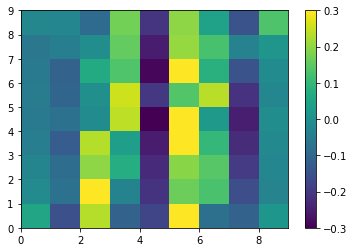

In [27]:
fig = plt.figure()
f = plt.pcolormesh(ARight, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

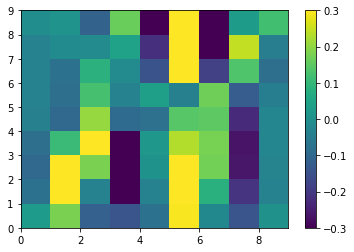

In [28]:
fig = plt.figure()
f = plt.pcolormesh(AFoot, vmin=-0.3, vmax=0.3)
plt.colorbar(f)

## Applying ML

In [29]:
X = np.stack([np.concatenate([a[:, 1], a[:, 3]]) for a in Adata])

In [30]:
X.shape

(224, 18)

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

#### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
Logclassifier = LogisticRegression(random_state = 0)
Logclassifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [33]:
y_pred_log = Logclassifier.predict(X_test)

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log)
print(cm)

[[19  3]
 [ 1 22]]


In [35]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = Logclassifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

Accuracy: 89.90 %
Standard Deviation: 7.87 %


#### Kernal SVM

In [36]:
from sklearn.svm import SVC
SVCclassifier = SVC(kernel = 'rbf', random_state = 0)
SVCclassifier.fit(X_train, y_train)

SVC(random_state=0)

In [37]:
y_pred_SVC = SVCclassifier.predict(X_test)

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_SVC)
print(cm)
accuracy_score(y_test, y_pred_SVC)

[[19  3]
 [ 2 21]]


0.8888888888888888

#### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
RFclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
RFclassifier.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [40]:
y_pred_RF = RFclassifier.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_RF)
print(cm)
accuracy_score(y_test, y_pred_RF)

[[19  3]
 [ 2 21]]


0.8888888888888888

#### KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier
KNNclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNNclassifier.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
y_pred_KNN = KNNclassifier.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_KNN)
print(cm)
accuracy_score(y_test, y_pred_KNN)

[[19  3]
 [ 3 20]]


0.8666666666666667

#### Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(X_train, y_train)

GaussianNB()

In [46]:
y_pred_NB = NBclassifier.predict(X_test)

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_NB)
print(cm)
accuracy_score(y_test, y_pred_NB)

[[20  2]
 [ 3 20]]


0.8888888888888888

In [48]:
from sklearn.metrics import roc_curve, auc

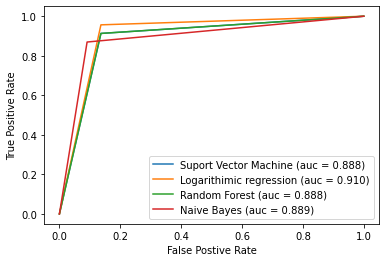

In [49]:
log_fpr, log_tpr, threshold = roc_curve(y_test, y_pred_log)
auc_log = auc(log_fpr, log_tpr)
SVC_fpr, SVC_tpr, threshold = roc_curve(y_test, y_pred_SVC)
auc_SVC = auc(SVC_fpr, SVC_tpr)
RF_fpr, RF_tpr, threshold = roc_curve(y_test, y_pred_RF)
auc_RF = auc(RF_fpr, RF_tpr)
KNN_fpr, KNN_tpr, threshold = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(KNN_fpr, KNN_tpr)
NB_fpr, NB_tpr, threshold = roc_curve(y_test, y_pred_NB)
auc_NB = auc(NB_fpr, NB_tpr)

plt.figure()
plt.plot(SVC_fpr, SVC_tpr, linestyle = '-', label = "Suport Vector Machine (auc = %0.3f)"%auc_SVC)
plt.plot(log_fpr, log_tpr, linestyle = '-', label = "Logarithimic regression (auc = %0.3f)"%auc_log)
plt.plot(RF_fpr, RF_tpr, linestyle = '-', label = "Random Forest (auc = %0.3f)"%auc_RF)
#plt.plot(KNN_fpr, KNN_tpr, linestyle = '-', label = "K-Nearest Neighbors (auc = %0.3f)"%auc_KNN)
plt.plot(NB_fpr, NB_tpr, linestyle = '-', label = "Naive Bayes (auc = %0.3f)"%auc_NB)

plt.xlabel("False Postive Rate")
plt.ylabel("True Positive Rate")

plt.legend()
plt.show()

#### MLP

In [50]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

In [51]:
dict = {-1: 0,1: 1}

for i in range(len(y_train)):
    y_train[i] = dict[y_train[i]]
    
num_classes = 2
y_train = tf.keras.utils.to_categorical(y_train, num_classes)

In [52]:
for i in range(len(y_test)):
    y_test[i] = dict[y_test[i]]
    
num_classes = 2
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [53]:
ip = tf.keras.Input(shape = 18)
dense1 = tf.keras.layers.Dense(units = 32, activation = "relu")(ip)
dense2 = tf.keras.layers.Dense(units = 32, activation = "relu")(dense1)
dense3 = tf.keras.layers.Dense(units = 16, activation = "relu")(dense2)
dense4 = tf.keras.layers.Dense(units = 8, activation = "relu")(dense3)
dense4 = tf.keras.layers.Dense(units = 2, activation = "sigmoid")(ip)

Model = tf.keras.models.Model(inputs = ip, outputs = dense4)
Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 38        
Total params: 38
Trainable params: 38
Non-trainable params: 0
_________________________________________________________________


In [54]:
Model.compile(loss = 'binary_crossentropy', metrics = ['acc'], optimizer = 'adam')

In [55]:
history = Model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test))

Epoch 1/200
6/6 [==============================] - 1s 29ms/step - loss: 0.7219 - acc: 0.4804 - val_loss: 0.7011 - val_acc: 0.5333
Epoch 2/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7165 - acc: 0.4860 - val_loss: 0.6944 - val_acc: 0.5333
Epoch 3/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7112 - acc: 0.5140 - val_loss: 0.6881 - val_acc: 0.5333
Epoch 4/200
6/6 [==============================] - 0s 6ms/step - loss: 0.7063 - acc: 0.5587 - val_loss: 0.6820 - val_acc: 0.5556
Epoch 5/200
6/6 [==============================] - 0s 7ms/step - loss: 0.7015 - acc: 0.5810 - val_loss: 0.6761 - val_acc: 0.5556
Epoch 6/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6965 - acc: 0.5866 - val_loss: 0.6706 - val_acc: 0.5778
Epoch 7/200
6/6 [==============================] - 0s 8ms/step - loss: 0.6920 - acc: 0.6034 - val_loss: 0.6649 - val_acc: 0.5778
Epoch 8/200
6/6 [==============================] - 0s 7ms/step - loss: 0.6875 - acc: 0.6089 - va

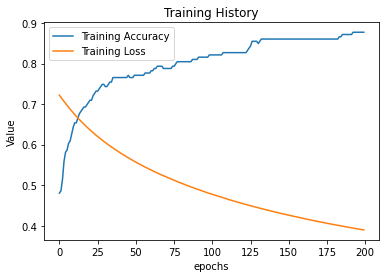

Initial training accuracy with preprocessing is:  0.4804469347000122
Final training accuracy with preprocessing is:  0.8770949840545654
Initial training loss with preprocessing is:  0.7218502759933472
Final training loss with preprocessing is:  0.38958966732025146


In [56]:
#Plotting model history
plt.plot(history.history['acc'])
plt.plot(history.history['loss'])
plt.legend(['Training Accuracy', 'Training Loss'])
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial training accuracy with preprocessing is: ", history.history['acc'][0])
print("Final training accuracy with preprocessing is: ", history.history['acc'][-1])

print("Initial training loss with preprocessing is: ", history.history['loss'][0])
print("Final training loss with preprocessing is: ", history.history['loss'][-1])

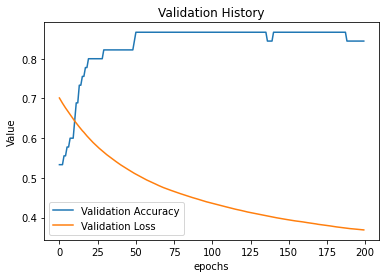

Initial Validation accuracy is:  0.5333333611488342
Best Validation accuracy is:  0.8666666746139526
Initial Validation loss is:  0.7011422514915466
Best Validation loss is:  0.36911359429359436


In [57]:
#Plotting model history
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_loss'])
plt.legend(['Validation Accuracy', 'Validation Loss'])
plt.title('Validation History')
plt.ylabel('Value')
plt.xlabel('epochs')
plt.show()
print("Initial Validation accuracy is: ", history.history['val_acc'][0])
print("Best Validation accuracy is: ", max(history.history['val_acc']))

print("Initial Validation loss is: ", history.history['val_loss'][0])
print("Best Validation loss is: ", min(history.history['val_loss']))